# Affinity Calculations using RDataFrame for CLAS12 Dihadron events

### Rowan Kelleher
#### October 20th, 2022

This notebook takes in TTrees and plots affinity values. TTrees come from LundAnalysis.C (in repo: https://github.com/RowanKell/MCLundAnalysis/blob/dev2/LundAnalysis.C)

Process:
1. Wildcard (\*) is used to take in many ROOT files into one RDataFrame for each bin variable for each pion
1. The means at each bin are then calculated using the Filter() and Mean() methods
1. These means are then fed through the Affinity TensorFlow model and affinity values are saved to numpy arrays
1. From these arrays we then plot affinity vs x, z, pT depending on the binning variable

In progress:
1. The dihadron affinity can be calculated from the product of the two pions, but this hasn't been done yet as the single pion affinity is still being worked on

In [1]:
from ROOT import TFile,TTree,TCanvas,TH1F,gStyle,TLatex,gPad,TLegend,TLorentzVector,TH2F,TLine,TF1,TBox,RDataFrame,TPad,TF2
import ROOT
import numpy as np
import awkward as awk
import uproot
import pandas as pd
import matplotlib.pyplot as plot
from pandas import read_excel 
from copy import deepcopy
from ipywidgets import *
import logging, os 
import time
logging.disable(logging.WARNING) 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
print("tf.__version__", tf.__version__)


Welcome to JupyROOT 6.22/06


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3ohufkkw because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


tf.__version__ 2.7.0


In [60]:
# d_plusq = RDataFrame("tree_MC_plus", "../../OutputFiles/Slurm/Oct_27/file_*.root").Filter("q_TdivQ < 0.3")
# d_minusq = RDataFrame("tree_MC_minus", "../../OutputFiles/Slurm/Oct_27/file_*.root").Filter("q_TdivQ < 0.3")

# d_plusR2 = RDataFrame("tree_MC_plus", "../../OutputFiles/Slurm/Oct_27/file_*.root").Filter("R2max < 0.3")
# d_minusR2 = RDataFrame("tree_MC_minus", "../../OutputFiles/Slurm/Oct_27/file_*.root").Filter("R2max < 0.3")

# d_plus = RDataFrame("tree_MC_plus", "../../OutputFiles/Slurm/Oct_27/file_*.root")
d_plus = RDataFrame("tree_postprocess","/volatile/clas12/users/gmat/clas12analysis.sidis.data/rga/MC/rowan_pipluspiminus/run*.root").Filter("run==-11")

# d_minus = RDataFrame("tree_MC_minus", "../../OutputFiles/Slurm/Oct_27/file_*.root")

In [61]:
print(d_plus.GetColumnNames())

{ "run", "x", "zh", "pt", "Q2", "Mx" }


In [62]:
#Bins (each has 8 including 0)
Mhbins = np.linspace(0,1.3,8)
pTbins = np.linspace(0.1,0.8,8)
xbins = np.array([0,0.1,0.13,0.16,0.19,0.235,0.3,0.5])
zbins = np.array([0,0.35,0.43,0.49,0.55,0.62,0.7,0.83])
Q2bins = np.array([0,1.2,1.8,2.3,3.1,4.3,7,11.1])

Need variables: x, z_h, Q2, p_T, R0, R1, R2 - total of 7

In [63]:
#Filtering data
#We have a list of 7 arrays bc we need an array of x values, z values, p_t values, etc for every bin
#First index will be the variable, second index is the i-th binning of that variable
#e.g. - px[1][3] will access the z_h mean for the 3rd (4th) bin of the x binning of piplus
# pxq = [np.zeros(7).tolist() for i in range(7)]
# pzq = [np.zeros(7).tolist() for i in range(7)]
# pMhq=[np.zeros(7).tolist() for i in range(7)]
# ppTq=[np.zeros(7).tolist() for i in range(7)]
# pxQ2q = [np.zeros(7).tolist() for i in range(7)]

# pxR2 = [np.zeros(7).tolist() for i in range(7)]
# pzR2 = [np.zeros(7).tolist() for i in range(7)]
# pMhR2=[np.zeros(7).tolist() for i in range(7)]
# ppTR2=[np.zeros(7).tolist() for i in range(7)]
# pxQ2R2 = [np.zeros(7).tolist() for i in range(7)]

px = [np.zeros(7).tolist() for i in range(7)]
pz = [np.zeros(7).tolist() for i in range(7)]
pMh=[np.zeros(7).tolist() for i in range(7)]
ppT=[np.zeros(7).tolist() for i in range(7)]
pxQ2 = [np.zeros(7).tolist() for i in range(7)]

In [64]:
#px=[list(np.zeros(7)) for i in range(7)]

In [65]:
varName = np.array(["x", "zh", "Q2", "pt", "R0max", "R1max", "R2max"])

In [66]:
start_time = time.time()
xformat = "x <= {} && x > {}"
zformat = "zh <= {} && zh > {}"
Mhformat = "Mh <= {} && Mh > {}"
pTformat = "pt <= {} && pt > {}"

#Piplus
#x bins
#i is the kinematic variable
#j is the bin num
for i in range(4):
    for j in range(7):
        #j + 1 as we only use 0 as a left bound, not a top bound - hence start with top bound at first index, not 0th
#         pxq[j][i] = d_plusq.Filter(xformat.format(xbins[j + 1],xbins[j])).Mean(varName[i])
#         pMhq[j][i] = d_plusq.Filter(Mhformat.format(Mhbins[j + 1],Mhbins[j])).Mean(varName[i])
#         pzq[j][i] = d_plusq.Filter(zformat.format(zbins[j + 1],zbins[j])).Mean(varName[i])
#         ppTq[j][i] = d_plusq.Filter(pTformat.format(pTbins[j + 1],pTbins[j])).Mean(varName[i])
        
#         pxR2[j][i] = d_plusR2.Filter(xformat.format(xbins[j + 1],xbins[j])).Mean(varName[i])
#         pMhR2[j][i] = d_plusR2.Filter(Mhformat.format(Mhbins[j + 1],Mhbins[j])).Mean(varName[i])
#         pzR2[j][i] = d_plusR2.Filter(zformat.format(zbins[j + 1],zbins[j])).Mean(varName[i])
#         ppTR2[j][i] = d_plusR2.Filter(pTformat.format(pTbins[j + 1],pTbins[j])).Mean(varName[i])
        
        px[j][i] = d_plus.Filter(xformat.format(xbins[j + 1],xbins[j])).Mean(varName[i])
#         pMh[j][i] = d_plus.Filter(Mhformat.format(Mhbins[j + 1],Mhbins[j])).Mean(varName[i])
        pz[j][i] = d_plus.Filter(zformat.format(zbins[j + 1],zbins[j])).Mean(varName[i])
        ppT[j][i] = d_plus.Filter(pTformat.format(pTbins[j + 1],pTbins[j])).Mean(varName[i])
        
        


In [67]:
print(px)

[[<cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x55e7250e83d0>, <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x55e7250a4070>, <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x55e72ef46d40>, <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x55e72eac5990>, 0.0, 0.0, 0.0], [<cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x55e7297fdee0>, <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x55e72825b0b0>, <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x55e72ef4e900>, <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x55e72eeeaf60>, 0.0, 0.0, 0.0], [<cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x55e72e761120>, <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x55e724f28e10>, <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x55e7252b3fe0>, <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x55e72ecf9ce0>, 0.0, 0.0, 0.0], [<cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x55e728f77740>, <cppyy.gbl.ROOT.RDF.RResultPtr<double> object at 0x55e724f08620>, <cppyy.gbl.ROOT.RDF.RRe

In [68]:
# c = TCanvas("c","c",500,500)
# h7 = pxdata.Histo1D(("h7",";R1 ;Counts", 1000, -1, 5), "R1max")
# h7.Draw("histo")
# c.Draw()
# # varName[5]

Now need to actually run the process by calling .GetValue() on one variable per RDataFrame (we have 2, one for each pion

In [69]:
#print(px)
forstart = time.time()
for i in range(4):
    for j in range(7):
        px[j][i]=px[j][i].GetValue()
#         pMh[i][j]=pMh[i][j].GetValue()
        pz[j][i] = pz[j][i].GetValue()
        ppT[j][i] = ppT[j][i].GetValue()
        
#         pxq[i][j]=pxq[i][j].GetValue()
#         pMhq[i][j]=pMhq[i][j].GetValue()
#         pzq[i][j] = pzq[i][j].GetValue()
#         ppTq[i][j] = ppTq[i][j].GetValue()
        
#         pxR2[i][j]=pxR2[i][j].GetValue()
#         pMhR2[i][j]=pMhR2[i][j].GetValue()
#         pzR2[i][j] = pzR2[i][j].GetValue()
#         ppTR2[i][j] = ppTR2[i][j].GetValue()
forend = time.time()
print("took: " + str(forend - forstart))

took: 5.774202108383179


In [70]:
print(px)

[[0.08835410781279461, -7.028425398469414e+286, 1.3487867203597903, 0.0544029422786479, 0.0, 0.0, 0.0], [0.11516773541454253, -7.016432405380637e+286, 1.6564092136908397, 0.055048853237054836, 0.0, 0.0, 0.0], [0.1443601200920486, -6.690328723656621e+286, 2.0169502553532057, 0.0546858158896511, 0.0, 0.0, 0.0], [0.17410648813329907, -6.638767067965838e+286, 2.4144619381658896, 0.0535572226856788, 0.0, 0.0, 0.0], [0.21031183500422765, -6.69103464910369e+286, 2.9297799410853895, 0.05441220000105894, 0.0, 0.0, 0.0], [0.2622448020549835, -6.799881948486883e+286, 3.6825978789200153, 0.05517021623966075, 0.0, 0.0, 0.0], [0.34712693000854383, -6.047111176773321e+286, 4.925822679091071, 0.05509585220383528, 0.0, 0.0, 0.0]]


In [53]:
collinear_region_name = 'collinear'
current_region_name = 'current'
target_region_name = 'target'
TMD_region_name = 'TMD'
soft_region_name = 'soft'
collinear_lable_name = 'collinearaff'
target_lable_name = 'targetaff'
current_lable_name = 'currentaff'
TMD_lable_name = 'tmdaff'
soft_lable_name = 'softaff'

tmd_model_name = '../../../SIDIS-Affinity/models/final_%s' % TMD_region_name
tmd_model = tf.keras.models.load_model(tmd_model_name)
target_model_name = '../../../SIDIS-Affinity/models/final_%s' % target_region_name
target_model = tf.keras.models.load_model(target_model_name)
collinear_model_name = '../../../SIDIS-Affinity/models/final_%s' % collinear_region_name
collinear_model = tf.keras.models.load_model(collinear_model_name)
current_model_name = '../../../SIDIS-Affinity/models/final_%s' % current_region_name
current_model = tf.keras.models.load_model(current_model_name)
soft_model_name = '../../../SIDIS-Affinity/models/final_%s' % soft_region_name
soft_model = tf.keras.models.load_model(soft_model_name)

varName = np.array(["x", "z", "Q2", "pT", "R0max", "R1max", "R2max"])

In [54]:
#var order: 
#0: x
#1: z_h
#2: Q2
#3: p_T
#4: R0
#5: R1
#6: R2

def calculator(array, region, binType, binnedVariable = 0):
    if binType == "x":
        z = array[1]
        Q2 = array[2]
        pT = array[3]
        R0max = 0
        R1max = 0
        R2max = 0
        x = binnedVariable
    elif binType == "z":
        x = array[0]
        Q2 = array[2]
        pT = array[3]
        R0max = 0
        R1max = 0
        R2max = 0
        z = binnedVariable
    elif binType == "pT":
        x = array[0]
        z = array[1]
        Q2 = array[2]
        pT = binnedVariable
        R0max = 0
        R1max = 0
        R2max = 0
        
#     elif binType == "Mh":
#         x = array[0]
#         z = array[1]
#         Q2 = array[2]
#         pT = array[3]
#         R0max = array[4]
#         R1max = array[5]
#         R2max = array[6]
        
    test_features = pd.DataFrame({'pT':pT,'Q2':Q2,'x':x,'z':z,'R0max':R0max,'R1max':R1max,'R2max':R2max},index=[0])

    if region == 'tmd':
        prediction = tmd_model.predict(test_features).flatten()
        
    elif region == 'target':
        prediction = target_model.predict(test_features).flatten()
        
    elif region == 'collinear':
        prediction = collinear_model.predict(test_features).flatten()

    elif region == 'soft':
        prediction = soft_model.predict(test_features).flatten()

    else:
        prediction = current_model.predict(test_features).flatten()

    return prediction[0] #returns affinity value

In [56]:
nocutscolxaffinityplus = np.zeros(7)
nocutscolzaffinityplus = np.zeros(7)
nocutscolpTaffinityplus = np.zeros(7)
# nocutscolMhaffinityplus = np.zeros(7)
nocutsTMDxaffinityplus = np.zeros(7)
nocutsTMDzaffinityplus = np.zeros(7)
nocutsTMDpTaffinityplus = np.zeros(7)
# nocutsTMDMhaffinityplus = np.zeros(7)
nocutsCurrentxaffinityplus = np.zeros(7)
nocutsCurrentzaffinityplus = np.zeros(7)
nocutsCurrentpTaffinityplus = np.zeros(7)
# nocutsCurrentMhaffinityplus = np.zeros(7)

region = "collinear"
region2 = "tmd"
region3 = "current"
for i in range(7):
    nocutscolzaffinityplus[i] = calculator(pz[i], region, "z", zbins[i+1])
    nocutscolxaffinityplus[i] = calculator(px[i], region, "x", xbins[i+1])
    nocutscolpTaffinityplus[i] = calculator(ppT[i], region, "pT", pTbins[i+1])
#     nocutscolMhaffinityplus[i] = calculator(pMh[i], region, "Mh", Mhbins[i+1])
    nocutsTMDzaffinityplus[i] = calculator(pz[i], region2, "z", zbins[i+1])
    nocutsTMDxaffinityplus[i] = calculator(px[i], region2, "x", xbins[i+1])
    nocutsTMDpTaffinityplus[i] = calculator(ppT[i], region2, "pT", pTbins[i+1])
#     nocutsTMDMhaffinityplus[i] = calculator(pMh[i], region2, "Mh", Mhbins[i+1])
    nocutsCurrentzaffinityplus[i] = calculator(pz[i], region3, "z", zbins[i+1])
    nocutsCurrentxaffinityplus[i] = calculator(px[i], region3, "x", xbins[i+1])
    nocutsCurrentpTaffinityplus[i] = calculator(ppT[i], region3, "pT", pTbins[i+1])
#     nocutsCurrentMhaffinityplus[i] = calculator(pMh[i], region3, "Mh", Mhbins[i+1])
    

In [57]:
Mhbinsno0 = np.linspace(0.3,1.3,7)
pTbinsno0 = np.linspace(0.2,0.8,7)
xbinsno0 = np.array([0.1,0.13,0.16,0.19,0.235,0.3,0.5])
zbinsno0 = np.array([0.35,0.43,0.49,0.55,0.62,0.7,0.83])

[Text(0, 0.5, 'Affinity')]

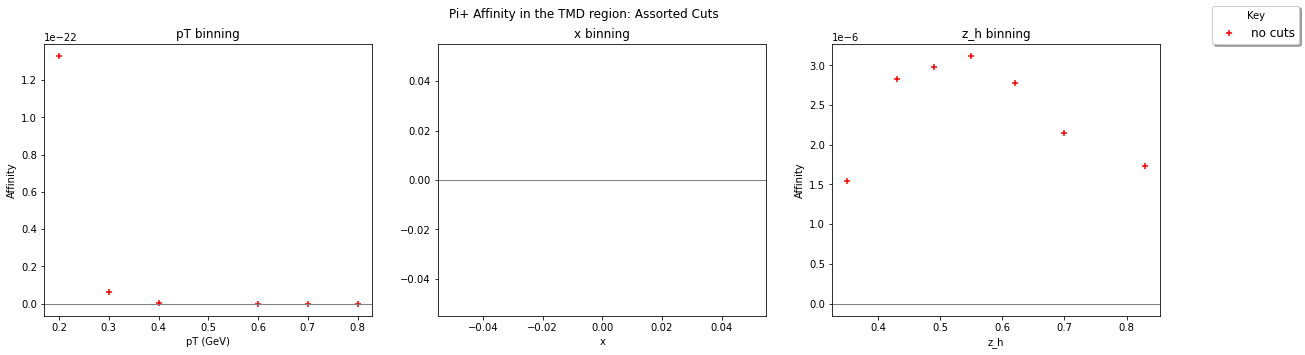

In [72]:
fig2, (ax12, ax22, ax32) = plot.subplots(1, 3, figsize = (20, 5))
fig2.suptitle("Pi+ Affinity in the TMD region: Assorted Cuts")
# fig2.ylable("Affinity")
ax12.set(ylabel = "Affinity")
ax12.scatter(pTbinsno0, nocutsTMDpTaffinityplus, c = 'r', marker = "+", label = "no cuts")
# ax12.scatter(pTbinsno0, qTMDpTaffinityplus, c = 'b', marker = "^", label = "qTdivQ < 0.3")
# ax12.scatter(pTbinsno0, R2TMDpTaffinityplus, c = 'g', marker = "*", label = "R2 < 0.3")
fig2.legend(shadow = "true", title = "Key", fontsize = 12)
ax12.axhline(y=0, color="gray", lw = 1)
ax12.set_title("pT binning")
ax12.set(xlabel = "pT (GeV)")
ax22.scatter(xbinsno0, nocutsTMDxaffinityplus, c = 'r', marker = '+', label = "no cuts")
# ax22.scatter(xbinsno0, qTMDxaffinityplus, c = 'b', marker = "^", label = "qTdivQ < 0.3")
# ax22.scatter(xbinsno0, R2TMDxaffinityplus, c = 'g', marker = "*", label = "R2 < 0.3")
ax22.axhline(y=0, color="gray", lw = 1)
ax22.set_title("x binning")
ax22.set(xlabel = "x")
ax32.scatter(zbinsno0, nocutsTMDzaffinityplus, c = 'r', marker = '+', label = "no cuts")
# ax32.scatter(zbinsno0, qTMDzaffinityplus, c = 'b', marker = "^", label = "qTdivQ < 0.3")
# ax32.scatter(zbinsno0, R2TMDzaffinityplus, c = 'g', marker = "*", label = "R2 < 0.3")
ax32.axhline(y=0, color="gray", lw = 1)
ax32.set_title("z_h binning")
ax32.set(xlabel = "z_h")
ax32.set(ylabel = "Affinity")
# plot.savefig("TMDallcuts.jpeg")


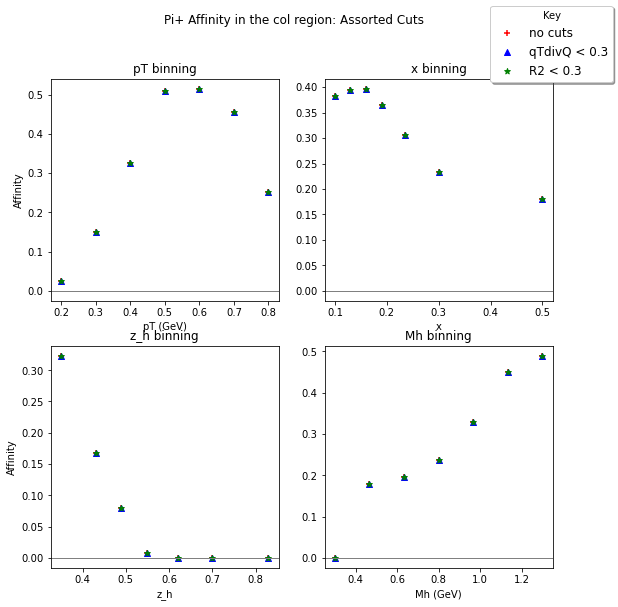

In [32]:
fig2, ((ax12, ax22), (ax32, ax42)) = plot.subplots(2, 2, figsize = (9, 9))
fig2.suptitle("Pi+ Affinity in the col region: Assorted Cuts")
# fig2.ylable("Affinity")
ax12.set(ylabel = "Affinity")
ax12.scatter(pTbinsno0, nocutscolpTaffinityplus, c = 'r', marker = "+", label = "no cuts")
ax12.scatter(pTbinsno0, qcolpTaffinityplus, c = 'b', marker = "^", label = "qTdivQ < 0.3")
ax12.scatter(pTbinsno0, R2colpTaffinityplus, c = 'g', marker = "*", label = "R2 < 0.3")
fig2.legend(shadow = "true", title = "Key", fontsize = 12)
ax12.axhline(y=0, color="gray", lw = 1)
ax12.set_title("pT binning")
ax12.set(xlabel = "pT (GeV)")
ax22.scatter(xbinsno0, nocutscolxaffinityplus, c = 'r', marker = '+', label = "no cuts")
ax22.scatter(xbinsno0, qcolxaffinityplus, c = 'b', marker = "^", label = "qTdivQ < 0.3")
ax22.scatter(xbinsno0, R2colxaffinityplus, c = 'g', marker = "*", label = "R2 < 0.3")
ax22.axhline(y=0, color="gray", lw = 1)
ax22.set_title("x binning")
ax22.set(xlabel = "x")
ax32.scatter(zbinsno0, nocutscolzaffinityplus, c = 'r', marker = '+', label = "no cuts")
ax32.scatter(zbinsno0, qcolzaffinityplus, c = 'b', marker = "^", label = "qTdivQ < 0.3")
ax32.scatter(zbinsno0, R2colzaffinityplus, c = 'g', marker = "*", label = "R2 < 0.3")
ax32.axhline(y=0, color="gray", lw = 1)
ax32.set_title("z_h binning")
ax32.set(xlabel = "z_h")
ax32.set(ylabel = "Affinity")
ax42.scatter(Mhbinsno0, nocutscolMhaffinityplus, c = 'r', marker = "+", label = "no cuts")
ax42.scatter(Mhbinsno0, qcolMhaffinityplus, c = 'b', marker = "^", label = "qTdivQ < 0.3")
ax42.scatter(Mhbinsno0, R2colMhaffinityplus, c = 'g', marker = "*", label = "R2 < 0.3")
ax42.axhline(y=0, color="gray", lw = 1)
ax42.set_title("Mh binning")
ax42.set(xlabel = "Mh (GeV)")
plot.savefig("colallcuts.jpeg")


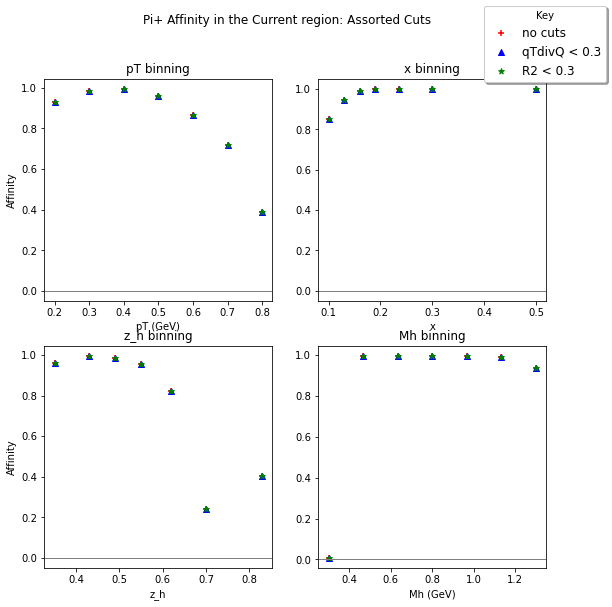

In [33]:
fig2, ((ax12, ax22), (ax32, ax42)) = plot.subplots(2, 2, figsize = (9, 9))
fig2.suptitle("Pi+ Affinity in the Current region: Assorted Cuts")
# fig2.ylable("Affinity")
ax12.set(ylabel = "Affinity")
ax12.scatter(pTbinsno0, nocutsCurrentpTaffinityplus, c = 'r', marker = "+", label = "no cuts")
ax12.scatter(pTbinsno0, qCurrentpTaffinityplus, c = 'b', marker = "^", label = "qTdivQ < 0.3")
ax12.scatter(pTbinsno0, R2CurrentpTaffinityplus, c = 'g', marker = "*", label = "R2 < 0.3")
fig2.legend(shadow = "true", title = "Key", fontsize = 12)
ax12.axhline(y=0, color="gray", lw = 1)
ax12.set_title("pT binning")
ax12.set(xlabel = "pT (GeV)")
ax22.scatter(xbinsno0, nocutsCurrentxaffinityplus, c = 'r', marker = '+', label = "no cuts")
ax22.scatter(xbinsno0, qCurrentxaffinityplus, c = 'b', marker = "^", label = "qTdivQ < 0.3")
ax22.scatter(xbinsno0, R2Currentxaffinityplus, c = 'g', marker = "*", label = "R2 < 0.3")
ax22.axhline(y=0, color="gray", lw = 1)
ax22.set_title("x binning")
ax22.set(xlabel = "x")
ax32.scatter(zbinsno0, nocutsCurrentzaffinityplus, c = 'r', marker = '+', label = "no cuts")
ax32.scatter(zbinsno0, qCurrentzaffinityplus, c = 'b', marker = "^", label = "qTdivQ < 0.3")
ax32.scatter(zbinsno0, R2Currentzaffinityplus, c = 'g', marker = "*", label = "R2 < 0.3")
ax32.axhline(y=0, color="gray", lw = 1)
ax32.set_title("z_h binning")
ax32.set(xlabel = "z_h")
ax32.set(ylabel = "Affinity")
ax42.scatter(Mhbinsno0, nocutsCurrentMhaffinityplus, c = 'r', marker = "+", label = "no cuts")
ax42.scatter(Mhbinsno0, qCurrentMhaffinityplus, c = 'b', marker = "^", label = "qTdivQ < 0.3")
ax42.scatter(Mhbinsno0, R2CurrentMhaffinityplus, c = 'g', marker = "*", label = "R2 < 0.3")
ax42.axhline(y=0, color="gray", lw = 1)
ax42.set_title("Mh binning")
ax42.set(xlabel = "Mh (GeV)")
plot.savefig("Currentallcuts.jpeg")
